We can generate a PDF using Kernel Density Estimation

Bandwidth factor: 0.31622776601683794
Covariance matrix:
 [[1.03321645e-04 1.27720679e-02]
 [1.27720679e-02 1.97885592e+00]]


Text(0.5, 1.0, 'Joint Density of $(\\alpha, k)$ using Gaussian KDE, $h$=0.3162')

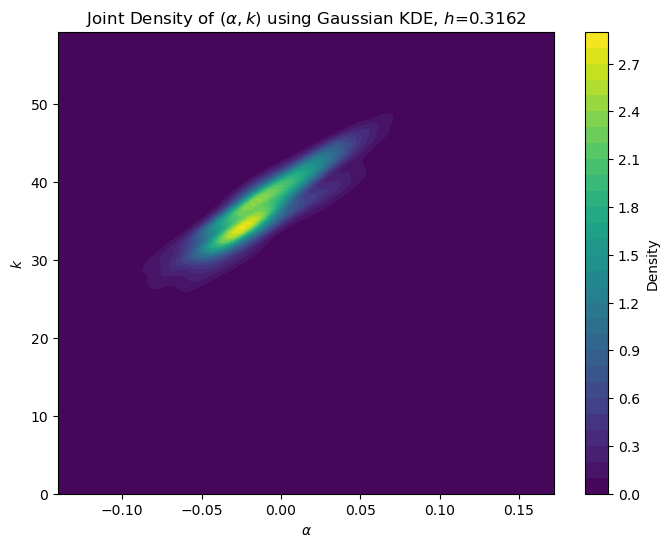

In [2]:
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("drucker_prager_params.csv")

data = np.vstack([df["alpha"], df["k"]])  # shape (2, N)
kde = gaussian_kde(data, bw_method='scott')

print("Bandwidth factor:", kde.factor)
print("Covariance matrix:\n", kde.covariance)
bandwidth_matrix = kde.factor ** 2 * np.cov(data)

alpha_grid = np.linspace(min(df["alpha"]) - 0.01, max(df["alpha"]) + 0.01, 100)
k_grid = np.linspace(0, max(df["k"]) + 5, 100)  # ensure k > 0
A, K = np.meshgrid(alpha_grid, k_grid)

# Flatten and stack grid for KDE evaluation
coords = np.vstack([A.ravel(), K.ravel()])
Z = kde(coords).reshape(A.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(A, K, Z, levels=30, cmap='viridis')
# plt.scatter(df["alpha"], df["k"], s=10, c='white', alpha=0.6)
plt.colorbar(label='Density')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$k$')
plt.title(rf'Joint Density of $(\alpha, k)$ using Gaussian KDE, $h$={kde.factor:.4f}')


The problem with this is that it doesn't respect the bounds. Instead, we can use copulas, where we can define each marginal distribution to one that respects the physical bounds of the problem, then model the relationship between the two variables with a copula.

In [3]:
from copulas.univariate import BetaUnivariate, GammaUnivariate
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_2d
import pandas as pd

df = pd.read_csv("drucker_prager_params.csv")
data = df.drop(columns="Seed")

dist = GaussianMultivariate(distribution={
    "alpha": BetaUnivariate(),
    "k": GammaUnivariate()
})

dist.fit(data)
sampled = dist.sample(1000)

compare_2d(data, sampled)

/home/avb25/miniforge/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniforge/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



To import the bounds properly, we must scale our data such that $[-\sqrt(3)/3, \sqrt(3)/3] \rightarrow [0, 1]$

In [19]:
from copulas.univariate import BetaUnivariate, GammaUnivariate
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_1d
from copulas.visualization import compare_2d
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("drucker_prager_params.csv")
data = df.drop(columns="Seed")

alpha_lower = -np.sqrt(3)/3
alpha_upper = np.sqrt(3)/3

# Rescale alpha to [0,1]
data_scaled = data.copy()
data_scaled["alpha"] = np.clip((data["alpha"] - alpha_lower) / (alpha_upper - alpha_lower), 0.01, 0.99)

# Fit copula with scaled alpha
dist = GaussianMultivariate(distribution={
    "alpha": BetaUnivariate(),
    "k": GammaUnivariate()
})

dist.fit(data_scaled)
sampled_scaled = dist.sample(1000)

# Unscale alpha back to original domain
sampled = sampled_scaled.copy()
sampled["alpha"] = sampled_scaled["alpha"] * (alpha_upper - alpha_lower) + alpha_lower

unscaled_beginning_data = data_scaled.copy()
unscaled_beginning_data["alpha"] = unscaled_beginning_data["alpha"] * (alpha_upper - alpha_lower) + alpha_lower

# Visual comparison
fig = compare_2d(unscaled_beginning_data, sampled)
fig.show()
fig = compare_1d(unscaled_beginning_data["alpha"], sampled["alpha"])
fig.show()
fig = compare_1d(unscaled_beginning_data["k"], sampled["k"])
fig.show()

/home/avb25/miniforge/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniforge/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



This looks good so far. Let's plot the actual PDF, not just samples

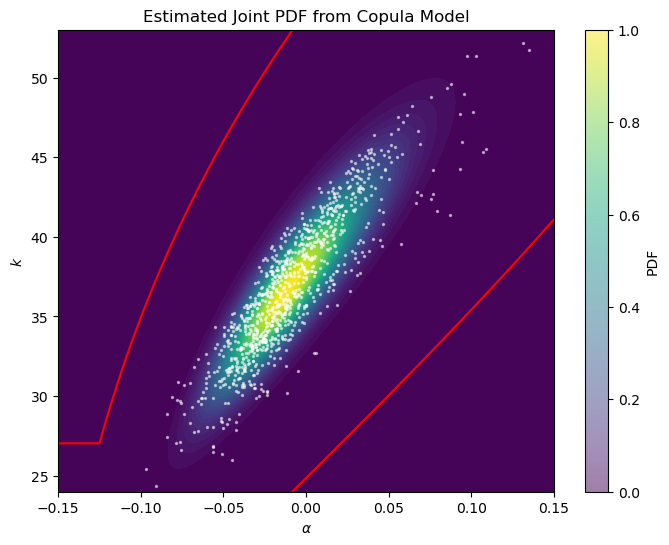

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Define physical ranges
x = np.linspace(-0.15, 0.15, 1000)
y = np.linspace(24, 53, 1000)
X, Y = np.meshgrid(x, y)

# Flatten grid into DataFrame (and scale alpha)
grid = pd.DataFrame({
    "alpha": np.clip((X.ravel() - alpha_lower) / (alpha_upper - alpha_lower), 0.01, 0.99),
    "k": Y.ravel()
})

# Evaluate PDF from copula model (returns array)
Z = dist.probability_density(grid)
Z = Z.reshape(X.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, cmap="viridis", levels=50)
plt.contour(X, Y, Z, levels=[1e-12], colors='red', linewidths=1.5)
plt.scatter(unscaled_beginning_data["alpha"], unscaled_beginning_data["k"], c='white', s=2, alpha=0.5)
plt.ylim(24, 53)
plt.xlim(-0.15, 0.15)

plt.colorbar(label='PDF')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$k$")
plt.title("Estimated Joint PDF from Copula Model")
plt.show()


We can extend this to look at each marginal as well, to ensure they are behaving correctly.

/home/avb25/miniforge/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniforge/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



{'loc': 0.35065417780917235, 'scale': 3.6131052945552478, 'a': 25.67344411013289, 'b': 631.4077331976483, 'type': 'copulas.univariate.beta.BetaUnivariate'}


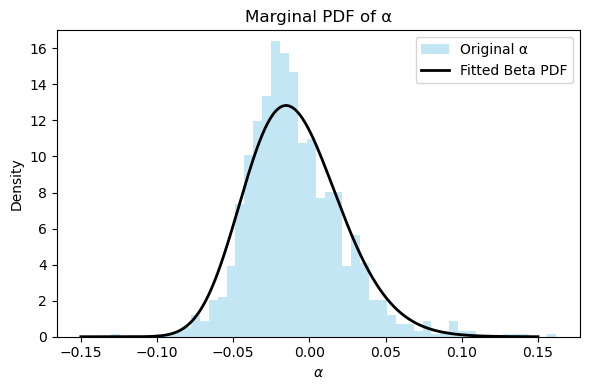

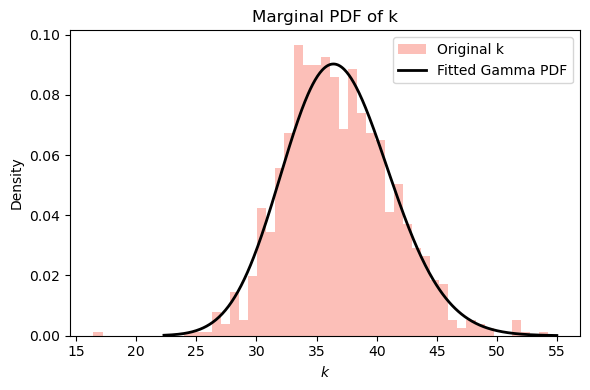

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta, gamma
from copulas.univariate import BetaUnivariate, GammaUnivariate
from scipy.stats import beta as beta_dist, gamma as gamma_dist


# Manually fit marginals on scaled data
alpha_scaled = data_scaled["alpha"].values
k_data = data_scaled["k"].values

data_clipped = data_scaled.copy()
data_clipped["alpha"] = data_clipped["alpha"] * (alpha_upper - alpha_lower) + alpha_lower

beta_uni = BetaUnivariate()
beta_uni.fit(alpha_scaled)
beta_params = beta_uni.to_dict()  # {'a': a, 'b': b}

gamma_uni = GammaUnivariate()
gamma_uni.fit(k_data)
gamma_params = gamma_uni.to_dict()  # {'alpha': shape, 'beta': rate}
print(beta_params)

# 1. Plot alpha
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(data_clipped["alpha"], bins=50, density=True, alpha=0.5,
         label="Original α", color="skyblue")

x_plot = np.linspace(-0.15, 0.15, 500)

# Convert to unit space (to match original fitted domain)
x_scaled = (x_plot - alpha_lower) / (alpha_upper - alpha_lower)

bp = beta_params
gp = gamma_params

# Evaluate fitted Beta PDF with loc/scale
pdf_alpha = beta_dist.pdf(
    x_scaled,
    a=bp["a"],
    b=bp["b"],
    loc=bp["loc"],
    scale=bp["scale"]
) / (alpha_upper - alpha_lower)  # Chain rule rescaling from unit space

plt.plot(x_plot, pdf_alpha, label="Fitted Beta PDF", color="black", lw=2)
# plt.plot([0.1, 0.1], [0, 18], color='red', linestyle='--', label='Cutoff')
plt.xlabel(r"$\alpha$")
plt.ylim(0, 17)
plt.ylabel("Density")
plt.title("Marginal PDF of α")
plt.legend()
plt.tight_layout()

# 2. Plot k
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(data_clipped["k"], bins=50, density=True, alpha=0.5,
         label="Original k", color="salmon")

x_k = np.linspace(min(sampled["k"]), max(sampled["k"]), 500)

# Evaluate fitted Gamma PDF with loc/scale
pdf_k = gamma_dist.pdf(
    x_k,
    a=gp["a"],
    loc=gp["loc"],
    scale=gp["scale"]
)

plt.plot(x_k, pdf_k, label="Fitted Gamma PDF", color="black", lw=2)
plt.xlabel(r"$k$")
plt.ylabel("Density")
plt.title("Marginal PDF of k")
plt.legend()
plt.tight_layout()

plt.show()


That PDF looked kind of weird in the corner, specifically the line at which $P=0$. To confirm our bounding is working correctly, we can go back artificially change our upper bound to be $0.1$, which is much closer to our data. This will allow us to see our bounding in action. If we do this and run the copula again (then visualize the PDFs), we see that they do not actually respect the bounds! This is a problem, and it seems to have something to do with the marginal beta distribution itself.

Let's use the `copulas` package to model just the marginal beta distribution

{'loc': 0.6008738624353311, 'scale': 3.0788449274954894, 'a': 24.908542992017807, 'b': 298.6922935633031, 'type': 'copulas.univariate.beta.BetaUnivariate'}


/home/avb25/miniforge/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning:

invalid value encountered in sqrt

/home/avb25/miniforge/envs/lammps/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning:

The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.



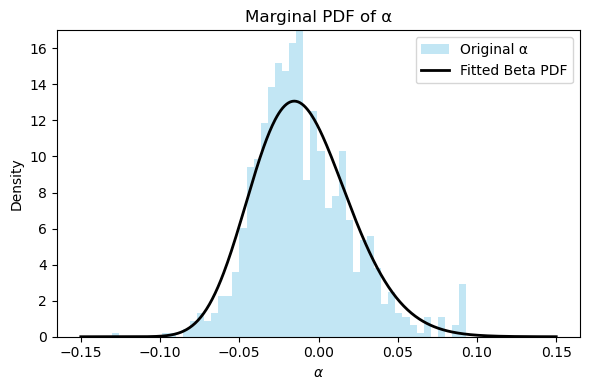

In [23]:
from copulas.univariate import BetaUnivariate, GammaUnivariate
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_1d
from copulas.visualization import compare_2d
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("drucker_prager_params.csv")
data = df.drop(columns="Seed")

alpha_lower = -np.sqrt(3)/3
alpha_upper = 0.1

# Rescale alpha to [0,1]
data_scaled = data.copy()
data_scaled["alpha"] = np.clip((data["alpha"] - alpha_lower) / (alpha_upper - alpha_lower), 0.01, 0.99)
data_clipped = data.copy()
data_clipped["alpha"] = data_scaled["alpha"] * (alpha_upper - alpha_lower) + alpha_lower
# Fit copula with scaled alpha
dist = BetaUnivariate()

dist.fit(data_scaled["alpha"])
sampled_scaled = dist.sample(1000)

# Unscale alpha back to original domain
sampled = sampled_scaled.copy()
sampled = sampled_scaled * (alpha_upper - alpha_lower) + alpha_lower

beta_params = dist.to_dict()

print(beta_params)

# 1. Plot alpha
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(data_clipped["alpha"], bins=50, density=True, alpha=0.5,
         label="Original α", color="skyblue")

x_plot = np.linspace(-0.15, 0.15, 500)

# Convert to unit space (to match original fitted domain)
x_scaled = (x_plot - alpha_lower) / (alpha_upper - alpha_lower)

bp = beta_params

# Evaluate fitted Beta PDF with loc/scale
pdf_alpha = beta_dist.pdf(
    x_scaled,
    a=bp["a"],
    b=bp["b"],
    loc=bp["loc"],
    scale=bp["scale"]
) / (alpha_upper - alpha_lower)  # Chain rule rescaling from unit space

plt.plot(x_plot, pdf_alpha, label="Fitted Beta PDF", color="black", lw=2)
# plt.plot([0.1, 0.1], [0, 18], color='red', linestyle='--', label='Cutoff')
plt.xlabel(r"$\alpha$")
plt.ylim(0, 17)
plt.ylabel("Density")
plt.title("Marginal PDF of α")
plt.legend()
plt.tight_layout()


fig = compare_1d(data["alpha"], sampled)
fig.show()


When we plot the PDF, we can confirm that the distribution does not respect the bound at 0.1. To confirm that this isn't me doing something wrong, let's do the same setup but with `scipy` on our scaled data, instead of `copulas`.

Scipy Beta Fit:
a: 35.5580, b: 6.8441, loc: 0, scale: 1


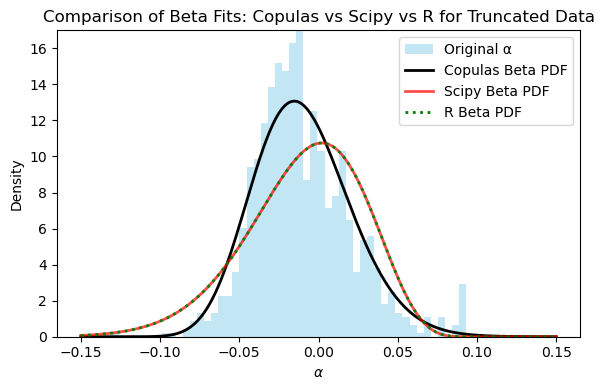

In [24]:
from scipy.stats import beta as beta_dist
from scipy.stats import beta as scipy_beta
import matplotlib.pyplot as plt

# 1. Fit Beta using scipy on scaled data
a_sci, b_sci, loc_sci, scale_sci = scipy_beta.fit(data_scaled["alpha"], floc=0, fscale=1)

print("Scipy Beta Fit:")
print(f"a: {a_sci:.4f}, b: {b_sci:.4f}, loc: {loc_sci}, scale: {scale_sci}")

# 2. Compare both fitted PDFs on unscaled domain
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(data_clipped["alpha"], bins=50, density=True, alpha=0.5,
         label="Original α", color="skyblue")

x_plot = np.linspace(-0.15, 0.15, 500)
x_scaled = (x_plot - alpha_lower) / (alpha_upper - alpha_lower)

# Copulas Beta PDF
pdf_copulas = beta_dist.pdf(
    x_scaled,
    a=bp["a"],
    b=bp["b"],
    loc=bp["loc"],
    scale=bp["scale"]
) / (alpha_upper - alpha_lower)

# Scipy Beta PDF
pdf_scipy = beta_dist.pdf(
    x_scaled,
    a=a_sci,
    b=b_sci,
    loc=0,
    scale=1
) / (alpha_upper - alpha_lower)

# R Beta PDF
pdf_R = beta_dist.pdf(
    x_scaled,
    a=35.55397,
    b=6.84320,
    loc=0,
    scale=1
) / (alpha_upper - alpha_lower)

plt.plot(x_plot, pdf_copulas, label="Copulas Beta PDF", color="black", lw=2)
plt.plot(x_plot, pdf_scipy, label="Scipy Beta PDF", color="red", lw=2, linestyle="-", alpha = 0.7)
plt.plot(x_plot, pdf_R, label="R Beta PDF", color="green", lw=2, linestyle=":")


plt.xlabel(r"$\alpha$")
plt.ylabel("Density")
plt.ylim(0, 17)
plt.title("Comparison of Beta Fits: Copulas vs Scipy vs R for Truncated Data")
plt.legend()
plt.tight_layout()
plt.show()


We can see that the `copulas` beta distribution does not come close to the `scipy` distribution. Additionally, we set up the same exact framework in `R`, and the `scipy` and `R` implementations matched perfectly.

The final verdict here is that the `copulas` package does not assume the input data for the Beta distribution is $\in [0, 1]$. Therefore, it learns the shape parameters (as normal), but also the `loc` and `scale` parameters. When the data is $\in [0, 1]$, `loc = 0` and `scale = 1`. This is a problem because it essentially causes the `copulas` package to stretch the data to best fit the distribution, ruining the bounds we created for it by scaling our data. 

Currently, the `copuals` package provides no way to set `loc` and `scale` constant beforehand (unlike `scipy`). This means that moving forward, we must use `R`.